<a href="https://colab.research.google.com/github/iochuu/CECS-456/blob/main/Chest_XRay_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [2]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import sklearn
import numpy as np
np.random.seed(42)
import matplotlib as mpl
import matplotlib.pyplot as plt

# Importing Dataset

In [3]:
#imports dataset from Kaggle
!pip install kaggle  #Install the Kaggle API client
from google.colab import files #Upload Kaggle API Key
files.upload()  #Upload the kaggle.json file
!mkdir -p ~/.kaggle #Next 3 lines set up Kaggle API Key
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

# Splitting the Dataset into Training, Validation, and Testing

In [4]:
# Define paths
train_dir = 'chest_xray/train'
val_dir = 'chest_xray/val'
test_dir = 'chest_xray/test'

# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Convert to tf.data.Dataset
def generator_to_dataset(generator):
    return tf.data.Dataset.from_generator(
        lambda: generator,
        output_signature=(
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.float32)
        )
    )

train_dataset = generator_to_dataset(train_generator).repeat()
val_dataset = generator_to_dataset(val_generator)
test_dataset = generator_to_dataset(test_generator)

# Prefetch to improve performance
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Building Neural Network

In [5]:
cnn = tf.keras.models.Sequential() #initializing the CNN
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=7, activation="relu", padding = "same", input_shape=[224, 224, 3])) #Convolution 1
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2)) #Pooling 1
cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding = "same")) #Convolution 2
cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding = "same")) #Convolution 3
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2)) #Pooling 2
cnn.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding = "same")) #Convolution 4
cnn.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding = "same")) #Convolution 5
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2)) #Pooling 3
cnn.add(tf.keras.layers.Flatten()) #Flattening
cnn.add(tf.keras.layers.Dense(units=128, activation="relu"))#Full Connection1
tf.keras.layers.Dropout(0.5)
cnn.add(tf.keras.layers.Dense(units=64, activation="relu"))#Full Connection2
tf.keras.layers.Dropout(0.5)
cnn.add(tf.keras.layers.Dense(units= 10, activation= "softmax"))#Output layer

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           9,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,815,306 (102.29 MB)

 Trainable params: 26,815,306 (102.29 MB)

 Non-trainable params: 0 (0.00 B)

# Compiling the Model

In [7]:
cnn.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# Training Neural Network Model

In [8]:
history = cnn.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 137s 699ms/step - accuracy: 0.6804 - loss: 1.2375 - val_accuracy: 0.5000 - val_loss: 0.7046
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 658ms/step - accuracy: 0.8075 - loss: 0.3938 - val_accuracy: 0.8750 - val_loss: 0.4076
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 664ms/step - accuracy: 0.8410 - loss: 0.3547 - val_accuracy: 0.8750 - val_loss: 0.4855
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 664ms/step - accuracy: 0.8722 - loss: 0.3017 - val_accuracy: 0.8125 - val_loss: 0.5950
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 657ms/step - accuracy: 0.8787 - loss: 0.2882 - val_accuracy: 0.8125 - val_loss: 0.5531
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 665ms/step - accuracy: 0.8948 - loss: 0.2680 - val_accuracy: 0.7500 - val_loss: 0.6605
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 663ms/step - accuracy: 0.8969 - loss: 0.2535 - val_accuracy: 0.6875 - val_loss: 0.8475
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 653ms/step - accuracy: 0.8889 -

# Evaluating Test Set

In [9]:
# Evaluating the model on the test set
test_loss, test_accuracy = cnn.evaluate(test_dataset, steps=len(test_generator))

# Printing the results
print(f"Total loss on testing set: {test_loss}")
print(f"Accuracy on testing set: {test_accuracy}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 283ms/step - accuracy: 0.7379 - loss: 0.6225
Total loss on testing set: 0.5874480605125427
Accuracy on testing set: 0.7291666865348816


# Predicting First 3 Images of Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


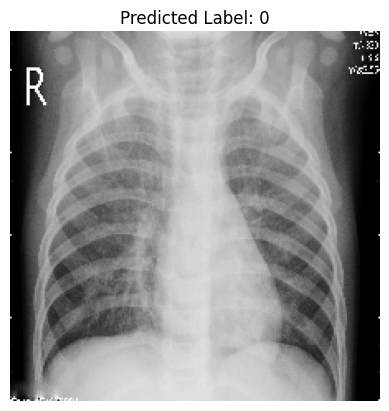

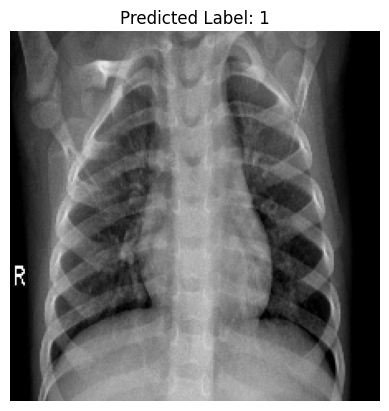

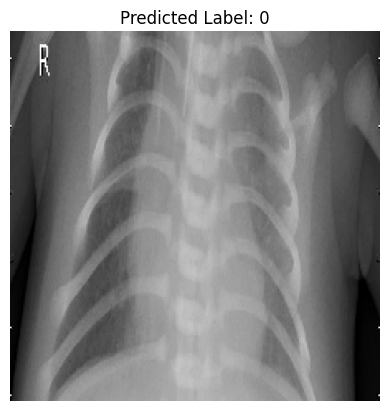

In [31]:
# Get the first batch of images and labels
images, labels = next(test_generator)

# Extract the first three images
first_three_images = images[:3]

# Make predictions on the first three images
predictions = cnn.predict(first_three_images)

# Convert predictions to class labels (assuming binary classification)
predicted_labels = (predictions > 0.5).astype(int)

# Display the images and their predicted labels
for i in range(3):
    plt.imshow(first_three_images[i])
    plt.title(f"Predicted Label: {predicted_labels[i][0]}")
    plt.axis('off')
    plt.show()